
**Atharv Bajaj**
**MTP - I**


In [ ]:
import os
import glob
import pandas as pd
import pandas as pd
import numpy as np
import os
from copy import deepcopy
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
import cvxpy as cp

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/MyDrive/mtp/dataset/'  # Folder containing the stock files
all_files = glob.glob(os.path.join(path, "*.csv"))

In [ ]:

for filename in all_files:
    df = pd.read_csv(filename)

    # Print the filename to identify the dataset
    print(f"Dataset: {filename}")

    # Print the first 5 rows of the dataset
    print(df.head())
    print("\n" + "-"*40 + "\n")  # Add a separator between datasets


Dataset: /content/drive/MyDrive/mtp/dataset/Quote-Equity-ITC-EQ-25-07-2024-to-25-10-2024.csv
         Date  series    OPEN    HIGH     LOW   PREV. CLOSE     ltp   close   \
0  24-Oct-2024      EQ  482.00  482.40  470.00        480.35  470.70  471.70   
1  23-Oct-2024      EQ  481.00  483.30  479.50        481.80  480.70  480.35   
2  22-Oct-2024      EQ  483.65  488.40  480.80        483.65  482.50  481.80   
3  21-Oct-2024      EQ  486.70  487.60  477.35        486.70  483.10  483.65   
4  18-Oct-2024      EQ  488.75  491.55  478.40        488.90  486.15  486.70   

    vwap   52W H   52W L       VOLUME               VALUE  No of trades   
0  474.32   528.5  399.35  1,30,92,399   6,20,99,65,225.20      2,40,152  
1  480.88   528.5  399.35  1,01,62,570   4,88,70,14,877.45      1,30,143  
2  483.80   528.5  399.35  1,22,99,288   5,95,04,54,269.80      1,94,079  
3  483.40   528.5  399.35    73,95,274   3,57,48,75,531.85      1,35,775  
4  482.63   528.5  399.35  2,17,78,099  10,51,08,19

**Data Preparation**

In [ ]:


def calculate_indicators(df):
    # Reverse the dataset so that the earliest date is at the top
    df = deepcopy(df)
    df = df.iloc[::-1].reset_index(drop=True)

    # Ensure date column is parsed correctly
    df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

    # Calculate K% (Stochastic Oscillator)
    df['L14'] = df['LOW'].rolling(window=9).min()
    df['H14'] = df['HIGH'].rolling(window=9).max()
    df['k%'] = 100 * ((df['close'] - df['L14']) / (df['H14'] - df['L14']))

    # Calculate RSI
    delta = df['close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=9).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=9).mean()
    df['RSI'] = 100 - (100 / (1 + gain / loss))

    # Calculate MACD and Signal Line
    ema_12 = df['close'].ewm(span=12, adjust=False).mean()
    ema_26 = df['close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = ema_12 - ema_26
    df['Signal Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

    df.reset_index(drop=True, inplace=True)
    # Calculate returns
    a = np.array(df['close'])
    returns = np.array((a[1:] - a[:-1]) / a[:-1])
    # print(returns)
    df = pd.DataFrame(np.array(df.values)[1:], columns=df.columns)
    # print(len(df.values), len(returns))
    df['return'] = returns
    print(returns)
    # df.reset_index(drop=True, inplace=True)
    # print(df.head(5))
    rets = []
    for i in range(4, len(df['return'])):
      ret = np.array(df['return'])[i-4:i]
      # print("hello", ret)
      rets.append(ret)
    # rets = list(filter(lambda x:len(x)==4, rets))
    rets = np.array(rets)

    # print(rets)

    df = pd.DataFrame(np.array(df.values)[-len(rets):], columns=df.columns)

    for i in range(len(rets[0])):
      df[f'r_t-{i+1}'] = rets[:,len(rets[0]) - i - 1]

    # Select and rename required columns
    df = df[['Date', 'OPEN', 'close', 'HIGH', 'LOW', 'VOLUME', 'k%', 'RSI', 'MACD', 'Signal Line', 'r_t-1', 'r_t-2', 'r_t-3', 'r_t-4', 'return']]
    df.columns = ['Date', 'Open', 'Close', 'High', 'Low', 'Volume', 'K%', 'RSI', 'MACD', 'Signal Line', 'r_t-1', 'r_t-2', 'r_t-3', 'r_t-4', 'Return']

    return df

# all_files = [...]  # List of file paths for all CSV files

for filename in all_files:
    # Load and clean data
    df = pd.read_csv(filename)
    df.columns = [i.strip() for i in df.columns]
    for col in ["OPEN", "HIGH", "LOW", "PREV. CLOSE", "ltp", "close", "vwap", "VOLUME", "VALUE"]:
        df[col] = pd.to_numeric(df[col].replace({',': ''}, regex=True))

    # Calculate indicators and returns on reversed data
    df_indicators = calculate_indicators(df)
    df_indicators=pd.DataFrame(np.array(df_indicators.values)[5:],columns=df_indicators.columns)
    # print(df_indicators
    print(df_indicators.head())
    print(df_indicators.tail())
    print("\n" + "-"*40 + "\n")
    # Save the modified dataframe to a new CSV
    output_filename = filename.replace('dataset', 'output')  # Change the path or filename as needed

    if not os.path.exists(output_filename):
      os.makedirs(os.path.dirname(output_filename), exist_ok=True)
    df_indicators.to_csv(output_filename, index=False)

    print(f"Saved: {output_filename}")


[ 2.50025513e-02 -1.22461171e-02 -1.23979438e-02  1.11247193e-02
 -3.33097810e-03 -9.31739923e-03 -6.33817215e-03  6.17283951e-04
  1.30577833e-02  4.26266112e-03  2.32440627e-03 -2.62149627e-03
 -9.30044480e-03  4.48979592e-03  2.12312068e-02 -2.38734706e-03
 -5.28467444e-03  1.32317562e-02 -1.68183617e-03  2.47745516e-03
 -1.97706603e-04 -1.00850307e-02 -6.59208949e-03  1.56846974e-02
 -6.33537913e-03  1.62382945e-02 -1.27438486e-03 -5.98743620e-03
  9.57835489e-03 -1.85837246e-02  2.00318916e-02  3.61504641e-03
  1.46028037e-03  1.00126373e-02 -1.08758422e-02 -5.35175635e-03
 -6.55449032e-03 -7.87789266e-04  1.77392333e-03  1.21003443e-02
  4.95723173e-03 -3.28851920e-03  4.46385250e-03  1.00473384e-02
 -9.56480153e-05 -8.70480199e-03 -3.76338898e-03 -6.68345602e-03
 -1.79424671e-02  1.32062357e-02 -4.41003528e-03 -3.19913377e-02
  7.11816148e-04 -7.82440809e-03  1.79229824e-02  3.21963980e-03
 -1.07311202e-02 -8.71857259e-03 -4.49989773e-03 -6.26669406e-03
 -3.82508012e-03 -3.00954

In [ ]:
path = '/content/drive/MyDrive/mtp/output/'  # Folder containing the stock files
all_files = glob.glob(os.path.join(path, "*.csv"))

**Predictive Model**

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [ ]:
def generate_random_weights(no_of_feature): #Generates an array of random numbers whose sum is approximately equal to 1.

    random_values = np.random.uniform(0, 1, no_of_feature)
    normalized_values = random_values / sum(random_values)
    return normalized_values

In [ ]:
import tensorflow as tf
# tf.compat.v1.enable_v2_behavior()
from tensorflow import keras

In [ ]:

model = tf.keras.models.Sequential([
    tf.keras.layers.Normalization(axis=-1, input_shape=(13,)),

    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ normalization (Normalization)        │ (None, 13)                  │              27 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 50)                  │             700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           1,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 4)                   │              36 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │               5 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,064 (11.97 KB)

 Trainable params: 3,037 (11.86 KB)

 Non-trainable params: 27 (112.00 B)

In [ ]:
def Arithmetic_crossover(parent1,parent2):
    ''' The oﬀsprings are created according to the equation:
            Off spring A = α ∗ Parent1 + (1 −α) ∗ Parent2
            Off spring B = (1 −α) ∗ Parent1 + α ∗ Parent2
            Where α is a random number between 0 and 1.
    '''
    alpha = np.random.rand()
    child1 = alpha * parent1 + (1-alpha) * parent2
    child2 = (1-alpha) * parent1 + alpha * parent2

    child1 /= np.sum(child1)
    child2 /= np.sum(child2)

    return child1,child2

In [ ]:

def cal_fitness_output(population,X,y,test=False):
  if len(X.columns) != len(population):
    raise ValueError("Length of population array must match the number of columns in X_train")
# Multiply each column of X_train with the corresponding index of population
  weighted_X_train = X* population
  if(not test):
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mean_squared_error'])
    model.fit(weighted_X_train, y, epochs = 20)
  # Predict on the training data
  y_pred = model.predict(weighted_X_train)
  return y_pred

In [ ]:
# this function is same as above the only difference is that it gives output of model rather than f1 score
def cal_fitness(population,X,y,test=False):
  if len(X.columns) != len(population):
    raise ValueError("Length of population array must match the number of columns in X_train")
# Multiply each column of X_train with the corresponding index of population
  weighted_X_train = X* population
  if(not test):
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mean_squared_error'])
    model.fit(weighted_X_train, y, epochs = 20)
  # Predict on the training data
  y_pred = model.predict(weighted_X_train)

  rmse = np.sqrt(mean_squared_error(y, y_pred))
  # Adding a small value to avoid division by zero
  return 1 / (rmse + 1e-8)  # Avoid division by zero

In [ ]:
# this function select elite population from the population it rejects 50% of population on the basis of fitness value
def select_elite_pop(population,X,y,test=False,fraction=0.7):
  population_fitness=[cal_fitness(x,X,y,test) for x in population]
  sorted_population_indices = np.argsort(population_fitness)[::-1]
  elite_population_indices = sorted_population_indices[:int(fraction * len(population))]
  elite_population = [population[i] for i in elite_population_indices]
  return elite_population

In [ ]:
def mutate(parent_chromosome): # Randomly swaps elements within a chromosome(or weights) to generate an offspring.

    child = parent_chromosome.copy()

    indices = np.random.choice(range(len(parent_chromosome)), 2, replace=False)
    child[indices[0]], child[indices[1]] = child[indices[1]], child[indices[0]]

    return child

In [ ]:
def generate_new_pop(population_size, elite_population, crossover_function=Arithmetic_crossover):
    #Generates a new population by utilizing mutation and crossover operations on the elite population.


    new_population = []
    elite_indices = range(len(elite_population))

    while len(new_population) < population_size:
        # here we define a mutation population to be 0.6 intially and after gaining certain population we reduce it to 0.1
        mutate_crossover_prob = 0.6 if len(new_population) <= 2 * population_size / 3 else 0.1

        # we generate random no and do mutation with probability p
        selected_operation = np.random.choice([0, 1], p=[1 - mutate_crossover_prob, mutate_crossover_prob])

        if selected_operation:
            index = np.random.choice(elite_indices)
            new_population.append(mutate(elite_population[index]))
        else:      # if not mutation we do crossover
            index_1, index_2 = np.random.choice(elite_indices, 2)     # randomly generate 2 indexes for crossover
            child_1, child_2 = crossover_function(elite_population[index_1], elite_population[index_2])

            # Check for negative gene values in child_1
            if any(gene < 0 for gene in child_1):
                index_1, index_2 = np.random.choice(elite_indices, 2)
                child_1, child_2 = crossover_function(elite_population[index_1], elite_population[index_2])

            new_population.extend([child_1, child_2])

    return new_population

In [ ]:
stocksreturns=[]
for filename in all_files:
    # Load data
    df = pd.read_csv(filename)

    # Remove the 'Date' column
    df = df.drop(columns=['Date'], errors='ignore')

    # Separate 'Return' column as the target (y) and the rest as features (X)
    X = df.drop(columns=['Return'], errors='ignore')
    y = df['Return'] if 'Return' in df.columns else None  # Check for 'Return' column existence

    # Separate the last row of X as X_test_last
    X_test_last = X.iloc[[-1]]  # Selecting the last row as a DataFrame
    y_test_last=y.iloc[[-1]]
    X = X.iloc[:-1]  # Removing the last row from X
    y = y.iloc[:-1] if y is not None else None  # Adjust y to exclude the last row

    # Normalize features X and X_test_last
    scaler_X = MinMaxScaler(feature_range=(-1, 1))
    X_normalized = pd.DataFrame(scaler_X.fit_transform(X), columns=X.columns)
    X_test_last_normalized = pd.DataFrame(scaler_X.transform(X_test_last), columns=X.columns)

    # Normalize target y if it exists
    if y is not None:
        scaler_y = MinMaxScaler(feature_range=(-1, 1))
        y_normalized = pd.DataFrame(scaler_y.fit_transform(y.values.reshape(-1, 1)), columns=['Return'])
    else:
        y_normalized = None
    X=X_normalized
    y=y_normalized
    p = 10  # Define population size
    no_of_samples = X_normalized.shape[1]
    # generation random weights for each set such that sum in a set is 1
    population=np.array([generate_random_weights(no_of_samples) for _ in range(p)])   #pop size will be population_size*no_of_samples
    # defining how many generation we want
    no_of_generation=10
    avg_fitness=[]
    all_fitness=[]
    print(X.shape)
    print(y.shape)
    for i in tqdm(range (no_of_generation)):
      # for each generation we will select top 70% of population
      elite_pop=select_elite_pop(population,X,y)
      fitness_of_pop=[]
      # for each individual we will fit it in model and append the predicition in fitness of pop
      for j in range (len(elite_pop)):
        fitness_of_pop.append(cal_fitness_output(elite_pop[j],X,y))
      # following part is just for taking avg
      if(len(fitness_of_pop)>0):
        transposed_data = list(map(list, zip(*fitness_of_pop)))
        column_averages = [sum(column) / len(column) for column in transposed_data]
        #print(column_averages)
      # appending the avg in avg_fitness
        avg_fitness.append(column_averages)
      population=generate_new_pop(p,elite_pop,Arithmetic_crossover)


    fitness=[]
    for i in range(len(avg_fitness)):
      y_pred=avg_fitness[i]
      f1=np.sqrt(mean_squared_error(y, y_pred))
      # Adding a small value to avoid division by zero
      f1=1 / (f1 + 1e-8)  # Avoid division by zero
      fitness.append(f1)


    fitness = [(fitness[i],i) for i in range(len(fitness))]
    fitness = sorted(fitness, key=lambda x: x[0])

    d=[]
    for i in range(1,len(fitness)):
      d.append((fitness[i][0]-fitness[i-1][0])*100)

    t=[0]*len(fitness)
    n=len(fitness)
    t[n-1]=1;
    for i in range(n-2,-1,-1):
      t[i]=fitness[i+1][0]**d[i]
    pref_prod=t.copy()
    pref_sum=t.copy()
    tot_sum=1
    for i in range(n-2,-1,-1):
      pref_prod[i]=pref_prod[i]*pref_prod[i+1]
      tot_sum+=pref_prod[i]
      pref_sum[i]=pref_sum[i]+pref_sum[i+1]
      #print(pref_prod[i],' ',pref_prod[i])
    # in weights we will be storing weights for each generation
    weights=[]
    for i in range(n):
      weights.append((pref_prod[i]/tot_sum,fitness[i][1]))

    # min_val = min(weights)
    # max_val = max(weights)
    # weights = [(x - min_val) / (max_val - min_val) for x in weights]
    weights = sorted(weights,key = lambda x:x[1])

    weights = [weights[i][0] for i in range(len(weights))]
    # m=sum(weights)
    # weights=[weights[i]/m for i in range(len(weights))]

    print(weights)

    final_y=[]
    for i in range(len(avg_fitness[0])):
      cur=0
      for j in range(len(avg_fitness)):
        cur+=weights[j]*avg_fitness[j][i]
      final_y.append(cur)
    print(np.sqrt(mean_squared_error(y, final_y)))


    ###test
    population_size=10
    no_of_samples=X_test_last.shape[1]
    population=np.array([generate_random_weights(no_of_samples) for _ in range(population_size)])   #pop size will be population_size*no_of_samples
    no_of_generation=10
    avg_fitness=[]
    all_fitness=[]
    for i in tqdm(range (no_of_generation)):
      elite_pop=select_elite_pop(population,X_test_last,y_test_last,True)
      fitness_of_pop=[]
      for j in range (len(elite_pop)):
        fitness_of_pop.append(cal_fitness_output(elite_pop[j],X_test_last,y_test_last,True))
      if(len(fitness_of_pop)>0):
        transposed_data = list(map(list, zip(*fitness_of_pop)))
        column_averages = [sum(column) / len(column) for column in transposed_data]
        #print(column_averages)
        avg_fitness.append(column_averages)
      population=generate_new_pop(population_size,elite_pop,Arithmetic_crossover)


    final_y=[]
    for i in range(len(avg_fitness[0])):
      cur=0
      for j in range(len(avg_fitness)):
        cur+=weights[j]*avg_fitness[j][i]
      final_y.append(cur)
    # converting it in binary values and calculating f1 score
    stocksreturns.append(final_y)


(53, 13)
(53, 1)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.2389 - mean_squared_error: 0.2389
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2218 - mean_squared_error: 0.2218 
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2371 - mean_squared_error: 0.2371 
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2097 - mean_squared_error: 0.2097 
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2255 - mean_squared_error: 0.2255 
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2039 - mean_squared_error: 0.2039 
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1969 - mean_squared_error: 0.1969 
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2044 - mean_squared_error: 0.2044 
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2083 - mean_squared_error: 0.2083 
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1997 - mean_squared_error: 0.1997 
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1933 - mea

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.1023 - mean_squared_error: 0.1023
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1069 - mean_squared_error: 0.1069 
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1063 - mean_squared_error: 0.1063 
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0893 - mean_squared_error: 0.0893 
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0964 - mean_squared_error: 0.0964
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1004 - mean_squared_error: 0.1004
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0855 - mean_squared_error: 0.0855 
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0992 - mean_squared_error: 0.0992
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0853 - mean_squared_error: 0.0853
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0961 - mean_squared_error: 0.0961
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━

 10%|█         | 1/10 [01:03<09:33, 63.70s/it]

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0814 - mean_squared_error: 0.0814
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0851 - mean_squared_error: 0.0851 
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0908 - mean_squared_error: 0.0908 
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0902 - mean_squared_error: 0.0902
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0900 - mean_squared_error: 0.0900 
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0832 - mean_squared_error: 0.0832 
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0912 - mean_squared_error: 0.0912 
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0826 - mean_squared_error: 0.0826 
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0741 - mean_squared_error: 0.0741
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0860 - mean_squared_error: 0.0860
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0745 - mea

 20%|██        | 2/10 [02:08<08:36, 64.59s/it]

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0433 - mean_squared_error: 0.0433
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0515 - mean_squared_error: 0.0515 
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0489 - mean_squared_error: 0.0489 
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0425 - mean_squared_error: 0.0425 
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0484 - mean_squared_error: 0.0484
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0354 - mean_squared_error: 0.0354 
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0357 - mean_squared_error: 0.0357 
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0430 - mean_squared_error: 0.0430
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0365 - mean_squared_error: 0.0365 
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0289 - mean_squared_error: 0.0289
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0420 - mea

 30%|███       | 3/10 [03:18<07:46, 66.70s/it]

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0390 - mean_squared_error: 0.0390
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0399 - mean_squared_error: 0.0399
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0285 - mean_squared_error: 0.0285
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0405 - mean_squared_error: 0.0405
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0405 - mean_squared_error: 0.0405 
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0306 - mean_squared_error: 0.0306 
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0400 - mean_squared_error: 0.0400 
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0378 - mean_squared_error: 0.0378 
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0305 - mean_squared_error: 0.0305 
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0382 - mean_squared_error: 0.0382
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0406 - me

 40%|████      | 4/10 [04:28<06:48, 68.08s/it]

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0279 - mean_squared_error: 0.0279
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0258 - mean_squared_error: 0.0258
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0387 - mean_squared_error: 0.0387 
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0349 - mean_squared_error: 0.0349 
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0348 - mean_squared_error: 0.0348 
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0270 - mean_squared_error: 0.0270 
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0297 - mean_squared_error: 0.0297
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0243 - mean_squared_error: 0.0243 
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0393 - mean_squared_error: 0.0393 
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0266 - mean_squared_error: 0.0266
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0361 - mea

 50%|█████     | 5/10 [05:39<05:46, 69.37s/it]

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0484 - mean_squared_error: 0.0484
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0330 - mean_squared_error: 0.0330
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0465 - mean_squared_error: 0.0465  
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0449 - mean_squared_error: 0.0449 
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0280 - mean_squared_error: 0.0280 
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0317 - mean_squared_error: 0.0317 
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0430 - mean_squared_error: 0.0430 
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0278 - mean_squared_error: 0.0278 
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0291 - mean_squared_error: 0.0291 
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0394 - mean_squared_error: 0.0394 
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.030

 60%|██████    | 6/10 [06:49<04:37, 69.37s/it]

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0338 - mean_squared_error: 0.0338
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0242 - mean_squared_error: 0.0242
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0261 - mean_squared_error: 0.0261
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0223 - mean_squared_error: 0.0223 
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0254 - mean_squared_error: 0.0254 
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0281 - mean_squared_error: 0.0281
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0375 - mean_squared_error: 0.0375
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0357 - mean_squared_error: 0.0357
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0332 - mean_squared_error: 0.0332 
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0352 - mean_squared_error: 0.0352
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0354 - m

 70%|███████   | 7/10 [08:01<03:31, 70.34s/it]

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0407 - mean_squared_error: 0.0407
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0359 - mean_squared_error: 0.0359 
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0386 - mean_squared_error: 0.0386 
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0231 - mean_squared_error: 0.0231
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0381 - mean_squared_error: 0.0381
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0273 - mean_squared_error: 0.0273 
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0252 - mean_squared_error: 0.0252 
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0275 - mean_squared_error: 0.0275
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0328 - mean_squared_error: 0.0328
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0227 - mean_squared_error: 0.0227
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0333 - me

 80%|████████  | 8/10 [09:17<02:24, 72.08s/it]

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0354 - mean_squared_error: 0.0354
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0350 - mean_squared_error: 0.0350
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0278 - mean_squared_error: 0.0278 
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0351 - mean_squared_error: 0.0351
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0243 - mean_squared_error: 0.0243
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0334 - mean_squared_error: 0.0334 
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0353 - mean_squared_error: 0.0353
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0271 - mean_squared_error: 0.0271 
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0280 - mean_squared_error: 0.0280 
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0347 - mean_squared_error: 0.0347 
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0360 - me

 90%|█████████ | 9/10 [10:34<01:13, 73.63s/it]

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0402 - mean_squared_error: 0.0402
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0360 - mean_squared_error: 0.0360
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0291 - mean_squared_error: 0.0291 
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0358 - mean_squared_error: 0.0358
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0381 - mean_squared_error: 0.0381 
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0357 - mean_squared_error: 0.0357  
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0333 - mean_squared_error: 0.0333
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0375 - mean_squared_error: 0.0375 
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0250 - mean_squared_error: 0.0250
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0351 - mean_squared_error: 0.0351 
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0327 -

100%|██████████| 10/10 [11:48<00:00, 70.82s/it]


[1.0, 1.410908162678055e-42, 5.815789051627341e-72, 3.143255634832752e-81, 1.6101958703023877e-86, 2.75212767764605e-88, 2.0322422459823086e-89, 3.2907072203343334e-90, 1.25291157223814e-90, 6.197906798060055e-91]
0.2283097339645554


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 10%|█         | 1/10 [00:01<00:14,  1.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 20%|██        | 2/10 [00:03<00:13,  1.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 30%|███       | 3/10 [00:05<00:12,  1.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 40%|████      | 4/10 [00:07<00:11,  1.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 50%|█████     | 5/10 [00:10<00:10,  2.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 60%|██████    | 6/10 [00:11<00:08,  2.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 70%|███████   | 7/10 [00:13<00:05,  1.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 80%|████████  | 8/10 [00:15<00:03,  1.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 90%|█████████ | 9/10 [00:17<00:01,  1.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


100%|██████████| 10/10 [00:18<00:00,  1.89s/it]


(53, 13)
(53, 1)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.6747 - mean_squared_error: 0.6747
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6056 - mean_squared_error: 0.6056
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.5548 - mean_squared_error: 0.5548 
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4645 - mean_squared_error: 0.4645  
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4123 - mean_squared_error: 0.4123
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3397 - mean_squared_error: 0.3397 
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2851 - mean_squared_error: 0.2851 
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2805 - mean_squared_error: 0.2805 
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2562 - mean_squared_error: 0.2562
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2230 - mean_squared_error: 0.2230
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2135

 10%|█         | 1/10 [01:13<11:04, 73.80s/it]

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.1550 - mean_squared_error: 0.1550
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1460 - mean_squared_error: 0.1460
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1318 - mean_squared_error: 0.1318
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1373 - mean_squared_error: 0.1373
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1441 - mean_squared_error: 0.1441
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1415 - mean_squared_error: 0.1415
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1418 - mean_squared_error: 0.1418 
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1443 - mean_squared_error: 0.1443
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1465 - mean_squared_error: 0.1465 
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1375 - mean_squared_error: 0.1375 
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1284 - me

 20%|██        | 2/10 [02:28<09:54, 74.25s/it]

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.1435 - mean_squared_error: 0.1435
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1425 - mean_squared_error: 0.1425
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1430 - mean_squared_error: 0.1430 
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1354 - mean_squared_error: 0.1354 
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1558 - mean_squared_error: 0.1558
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1285 - mean_squared_error: 0.1285 
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1325 - mean_squared_error: 0.1325
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1474 - mean_squared_error: 0.1474 
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1317 - mean_squared_error: 0.1317 
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1404 - mean_squared_error: 0.1404 
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1541 - m

 30%|███       | 3/10 [03:42<08:40, 74.40s/it]

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1252 - mean_squared_error: 0.1252
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1378 - mean_squared_error: 0.1378
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1375 - mean_squared_error: 0.1375 
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1403 - mean_squared_error: 0.1403
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1477 - mean_squared_error: 0.1477 
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1348 - mean_squared_error: 0.1348
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1301 - mean_squared_error: 0.1301
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1537 - mean_squared_error: 0.1537 
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1313 - mean_squared_error: 0.1313 
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1359 - mean_squared_error: 0.1359 
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1295 - m

 40%|████      | 4/10 [04:56<07:24, 74.10s/it]

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.1401 - mean_squared_error: 0.1401
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1386 - mean_squared_error: 0.1386 
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1280 - mean_squared_error: 0.1280 
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1209 - mean_squared_error: 0.1209 
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1494 - mean_squared_error: 0.1494
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1283 - mean_squared_error: 0.1283 
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1320 - mean_squared_error: 0.1320 
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1253 - mean_squared_error: 0.1253 
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1411 - mean_squared_error: 0.1411
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1554 - mean_squared_error: 0.1554
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1383 - me

 50%|█████     | 5/10 [06:11<06:12, 74.54s/it]

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1310 - mean_squared_error: 0.1310
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1465 - mean_squared_error: 0.1465
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1419 - mean_squared_error: 0.1419 
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1350 - mean_squared_error: 0.1350
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1350 - mean_squared_error: 0.1350
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1348 - mean_squared_error: 0.1348
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1347 - mean_squared_error: 0.1347 
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1279 - mean_squared_error: 0.1279 
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1396 - mean_squared_error: 0.1396
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1394 - mean_squared_error: 0.1394 
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1320 -

 60%|██████    | 6/10 [07:33<05:07, 76.92s/it]

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.1482 - mean_squared_error: 0.1482
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1454 - mean_squared_error: 0.1454
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1373 - mean_squared_error: 0.1373
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1346 - mean_squared_error: 0.1346
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1361 - mean_squared_error: 0.1361  
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1490 - mean_squared_error: 0.1490 
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1282 - mean_squared_error: 0.1282 
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1324 - mean_squared_error: 0.1324 
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1358 - mean_squared_error: 0.1358 
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1509 - mean_squared_error: 0.1509
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1301 - me

 70%|███████   | 7/10 [08:48<03:48, 76.18s/it]

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.1388 - mean_squared_error: 0.1388
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1238 - mean_squared_error: 0.1238
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1439 - mean_squared_error: 0.1439
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1381 - mean_squared_error: 0.1381
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1356 - mean_squared_error: 0.1356 
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1265 - mean_squared_error: 0.1265
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1385 - mean_squared_error: 0.1385 
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1269 - mean_squared_error: 0.1269 
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1316 - mean_squared_error: 0.1316
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1490 - mean_squared_error: 0.1490
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1409 - m

 80%|████████  | 8/10 [10:05<02:33, 76.61s/it]

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.1467 - mean_squared_error: 0.1467
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1524 - mean_squared_error: 0.1524 
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1302 - mean_squared_error: 0.1302
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1454 - mean_squared_error: 0.1454 
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1357 - mean_squared_error: 0.1357 
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1375 - mean_squared_error: 0.1375
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1456 - mean_squared_error: 0.1456 
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1479 - mean_squared_error: 0.1479 
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1398 - mean_squared_error: 0.1398
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1393 - mean_squared_error: 0.1393
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1320 -

 90%|█████████ | 9/10 [11:25<01:17, 77.48s/it]

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.1271 - mean_squared_error: 0.1271
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1220 - mean_squared_error: 0.1220
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1293 - mean_squared_error: 0.1293
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1497 - mean_squared_error: 0.1497 
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1336 - mean_squared_error: 0.1336 
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1267 - mean_squared_error: 0.1267 
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1437 - mean_squared_error: 0.1437
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1419 - mean_squared_error: 0.1419  
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1398 - mean_squared_error: 0.1398
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1340 - mean_squared_error: 0.1340
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1287 -

100%|██████████| 10/10 [12:41<00:00, 76.14s/it]


[0.14335776185424537, 0.1005149885180801, 0.09917292452147136, 0.09656493301528499, 0.09528937549691353, 0.09422339955942713, 0.09343337086927599, 0.09282721100048905, 0.0924493993920765, 0.09216663577273604]
0.37139150747512645


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 10%|█         | 1/10 [00:02<00:19,  2.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 20%|██        | 2/10 [00:04<00:18,  2.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 30%|███       | 3/10 [00:07<00:16,  2.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 40%|████      | 4/10 [00:09<00:13,  2.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 50%|█████     | 5/10 [00:11<00:10,  2.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 60%|██████    | 6/10 [00:12<00:08,  2.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 70%|███████   | 7/10 [00:14<00:05,  1.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 80%|████████  | 8/10 [00:16<00:03,  1.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 90%|█████████ | 9/10 [00:18<00:01,  1.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


100%|██████████| 10/10 [00:21<00:00,  2.14s/it]


(53, 13)
(53, 1)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.2791 - mean_squared_error: 0.2791
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2581 - mean_squared_error: 0.2581
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2577 - mean_squared_error: 0.2577
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2231 - mean_squared_error: 0.2231  
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2414 - mean_squared_error: 0.2414 
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2261 - mean_squared_error: 0.2261 
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2409 - mean_squared_error: 0.2409
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2401 - mean_squared_error: 0.2401 
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2375 - mean_squared_error: 0.2375
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2663 - mean_squared_error: 0.2663
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2457 - m

 10%|█         | 1/10 [01:14<11:08, 74.24s/it]

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.2243 - mean_squared_error: 0.2243
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2246 - mean_squared_error: 0.2246
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2421 - mean_squared_error: 0.2421
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2247 - mean_squared_error: 0.2247
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2238 - mean_squared_error: 0.2238
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2384 - mean_squared_error: 0.2384
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2205 - mean_squared_error: 0.2205
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2465 - mean_squared_error: 0.2465
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2446 - mean_squared_error: 0.2446
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2264 - mean_squared_error: 0.2264 
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2417 - me

 20%|██        | 2/10 [02:25<09:42, 72.77s/it]

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.2325 - mean_squared_error: 0.2325
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2131 - mean_squared_error: 0.2131
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2118 - mean_squared_error: 0.2118
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2216 - mean_squared_error: 0.2216
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2082 - mean_squared_error: 0.2082
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2034 - mean_squared_error: 0.2034 
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2081 - mean_squared_error: 0.2081 
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1918 - mean_squared_error: 0.1918
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2063 - mean_squared_error: 0.2063
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2117 - mean_squared_error: 0.2117
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2099 - 

 30%|███       | 3/10 [03:51<09:11, 78.81s/it]

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.2441 - mean_squared_error: 0.2441
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2100 - mean_squared_error: 0.2100
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2047 - mean_squared_error: 0.2047 
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1963 - mean_squared_error: 0.1963
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2087 - mean_squared_error: 0.2087 
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2127 - mean_squared_error: 0.2127 
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2253 - mean_squared_error: 0.2253
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2101 - mean_squared_error: 0.2101
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2248 - mean_squared_error: 0.2248  
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2173 - mean_squared_error: 0.2173 
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2139 - m

 40%|████      | 4/10 [05:05<07:39, 76.59s/it]

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.2241 - mean_squared_error: 0.2241
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1951 - mean_squared_error: 0.1951
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2061 - mean_squared_error: 0.2061
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1990 - mean_squared_error: 0.1990 
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1857 - mean_squared_error: 0.1857 
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1881 - mean_squared_error: 0.1881 
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1916 - mean_squared_error: 0.1916
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1819 - mean_squared_error: 0.1819 
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1861 - mean_squared_error: 0.1861 
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1642 - mean_squared_error: 0.1642
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1954 - mea

 50%|█████     | 5/10 [06:28<06:34, 78.85s/it]

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.1767 - mean_squared_error: 0.1767
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1875 - mean_squared_error: 0.1875
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1877 - mean_squared_error: 0.1877
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1813 - mean_squared_error: 0.1813 
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1795 - mean_squared_error: 0.1795
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1818 - mean_squared_error: 0.1818
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1838 - mean_squared_error: 0.1838
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1775 - mean_squared_error: 0.1775 
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1935 - mean_squared_error: 0.1935 
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1856 - mean_squared_error: 0.1856 
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1721 - me

 60%|██████    | 6/10 [07:46<05:15, 78.85s/it]

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.1729 - mean_squared_error: 0.1729
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2010 - mean_squared_error: 0.2010 
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1910 - mean_squared_error: 0.1910 
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1823 - mean_squared_error: 0.1823 
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1871 - mean_squared_error: 0.1871
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1890 - mean_squared_error: 0.1890  
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1730 - mean_squared_error: 0.1730 
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1730 - mean_squared_error: 0.1730 
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1646 - mean_squared_error: 0.1646 
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1809 - mean_squared_error: 0.1809 
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1787 - m

 70%|███████   | 7/10 [09:05<03:55, 78.62s/it]

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.1559 - mean_squared_error: 0.1559
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1905 - mean_squared_error: 0.1905
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1774 - mean_squared_error: 0.1774
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1895 - mean_squared_error: 0.1895 
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1673 - mean_squared_error: 0.1673
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1723 - mean_squared_error: 0.1723 
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1807 - mean_squared_error: 0.1807 
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1863 - mean_squared_error: 0.1863 
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1785 - mean_squared_error: 0.1785  
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1776 - mean_squared_error: 0.1776
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1787 -

 80%|████████  | 8/10 [10:34<02:44, 82.20s/it]

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.1843 - mean_squared_error: 0.1843
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1878 - mean_squared_error: 0.1878
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1938 - mean_squared_error: 0.1938 
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1963 - mean_squared_error: 0.1963
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1910 - mean_squared_error: 0.1910
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1934 - mean_squared_error: 0.1934
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1967 - mean_squared_error: 0.1967 
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1869 - mean_squared_error: 0.1869
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2070 - mean_squared_error: 0.2070
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1867 - mean_squared_error: 0.1867
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1788 - me

 90%|█████████ | 9/10 [11:55<01:21, 81.75s/it]

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.1711 - mean_squared_error: 0.1711
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1726 - mean_squared_error: 0.1726
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1627 - mean_squared_error: 0.1627 
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1740 - mean_squared_error: 0.1740 
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1824 - mean_squared_error: 0.1824
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1877 - mean_squared_error: 0.1877
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2023 - mean_squared_error: 0.2023 
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1838 - mean_squared_error: 0.1838
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1877 - mean_squared_error: 0.1877 
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1683 - mean_squared_error: 0.1683
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1830 -

100%|██████████| 10/10 [13:19<00:00, 79.95s/it]


[0.778945675957752, 0.18711911239096782, 0.03347802504195997, 0.00037178676301137216, 2.8288161094521177e-05, 2.603170530882395e-05, 2.5912111186869375e-05, 3.862840375632236e-06, 6.533463425270676e-07, 6.51682000429453e-07]
0.44778679411589045


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 10%|█         | 1/10 [00:02<00:24,  2.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 20%|██        | 2/10 [00:05<00:22,  2.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 30%|███       | 3/10 [00:08<00:19,  2.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 40%|████      | 4/10 [00:11<00:16,  2.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 50%|█████     | 5/10 [00:13<00:13,  2.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 60%|██████    | 6/10 [00:15<00:10,  2.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 70%|███████   | 7/10 [00:18<00:07,  2.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 80%|████████  | 8/10 [00:20<00:04,  2.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 90%|█████████ | 9/10 [00:23<00:02,  2.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


100%|██████████| 10/10 [00:26<00:00,  2.62s/it]


(53, 13)
(53, 1)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0782 - mean_squared_error: 0.0782
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0843 - mean_squared_error: 0.0843
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0688 - mean_squared_error: 0.0688 
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0763 - mean_squared_error: 0.0763
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0764 - mean_squared_error: 0.0764
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0747 - mean_squared_error: 0.0747  
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0674 - mean_squared_error: 0.0674
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0694 - mean_squared_error: 0.0694
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0672 - mean_squared_error: 0.0672 
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0771 - mean_squared_error: 0.0771 
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0721 - m

 10%|█         | 1/10 [01:19<11:58, 79.87s/it]

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0540 - mean_squared_error: 0.0540
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0497 - mean_squared_error: 0.0497 
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0516 - mean_squared_error: 0.0516
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0578 - mean_squared_error: 0.0578 
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0551 - mean_squared_error: 0.0551 
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0474 - mean_squared_error: 0.0474 
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0532 - mean_squared_error: 0.0532 
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0490 - mean_squared_error: 0.0490
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0516 - mean_squared_error: 0.0516 
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0609 - mean_squared_error: 0.0609 
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0610 - me

 20%|██        | 2/10 [02:43<10:57, 82.19s/it]

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.4805 - mean_squared_error: 0.4805
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4293 - mean_squared_error: 0.4293
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3809 - mean_squared_error: 0.3809 
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3386 - mean_squared_error: 0.3386 
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3289 - mean_squared_error: 0.3289 
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2834 - mean_squared_error: 0.2834 
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2146 - mean_squared_error: 0.2146 
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1522 - mean_squared_error: 0.1522 
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1254 - mean_squared_error: 0.1254
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0920 - mean_squared_error: 0.0920 
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0755 - me

 30%|███       | 3/10 [04:04<09:30, 81.57s/it]

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0644 - mean_squared_error: 0.0644
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0582 - mean_squared_error: 0.0582
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0474 - mean_squared_error: 0.0474  
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0547 - mean_squared_error: 0.0547 
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0588 - mean_squared_error: 0.0588
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0551 - mean_squared_error: 0.0551
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0492 - mean_squared_error: 0.0492
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0384 - mean_squared_error: 0.0384
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0512 - mean_squared_error: 0.0512 
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0492 - mean_squared_error: 0.0492 
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0445 - 

 40%|████      | 4/10 [05:37<08:36, 86.16s/it]

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0517 - mean_squared_error: 0.0517
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0463 - mean_squared_error: 0.0463 
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0505 - mean_squared_error: 0.0505 
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0486 - mean_squared_error: 0.0486  
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0363 - mean_squared_error: 0.0363 
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0366 - mean_squared_error: 0.0366 
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0369 - mean_squared_error: 0.0369 
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0509 - mean_squared_error: 0.0509 
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0492 - mean_squared_error: 0.0492
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0496 - mean_squared_error: 0.0496
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0513

 50%|█████     | 5/10 [07:03<07:10, 86.07s/it]

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0537 - mean_squared_error: 0.0537
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0442 - mean_squared_error: 0.0442
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0351 - mean_squared_error: 0.0351
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0401 - mean_squared_error: 0.0401 
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0337 - mean_squared_error: 0.0337
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0506 - mean_squared_error: 0.0506 
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0495 - mean_squared_error: 0.0495 
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0453 - mean_squared_error: 0.0453 
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0398 - mean_squared_error: 0.0398
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0501 - mean_squared_error: 0.0501
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0492 - me

 60%|██████    | 6/10 [08:33<05:49, 87.27s/it]

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0390 - mean_squared_error: 0.0390
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0424 - mean_squared_error: 0.0424
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0520 - mean_squared_error: 0.0520
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0485 - mean_squared_error: 0.0485
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0505 - mean_squared_error: 0.0505
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0456 - mean_squared_error: 0.0456
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0334 - mean_squared_error: 0.0334 
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0507 - mean_squared_error: 0.0507
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0486 - mean_squared_error: 0.0486
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0389 - mean_squared_error: 0.0389
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0479 - me

 70%|███████   | 7/10 [09:55<04:17, 85.70s/it]

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0470 - mean_squared_error: 0.0470
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0498 - mean_squared_error: 0.0498
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0383 - mean_squared_error: 0.0383
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0442 - mean_squared_error: 0.0442
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0491 - mean_squared_error: 0.0491
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0350 - mean_squared_error: 0.0350
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0490 - mean_squared_error: 0.0490 
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0436 - mean_squared_error: 0.0436
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0329 - mean_squared_error: 0.0329
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0394 - mean_squared_error: 0.0394 
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0349 - me

 80%|████████  | 8/10 [11:25<02:53, 86.87s/it]

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0494 - mean_squared_error: 0.0494
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0508 - mean_squared_error: 0.0508
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0423 - mean_squared_error: 0.0423
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0369 - mean_squared_error: 0.0369
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0513 - mean_squared_error: 0.0513
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0377 - mean_squared_error: 0.0377
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0509 - mean_squared_error: 0.0509 
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0396 - mean_squared_error: 0.0396  
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0409 - mean_squared_error: 0.0409 
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0414 - mean_squared_error: 0.0414
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0396 -

 90%|█████████ | 9/10 [12:53<01:27, 87.30s/it]

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0543 - mean_squared_error: 0.0543
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0525 - mean_squared_error: 0.0525
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0554 - mean_squared_error: 0.0554
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0401 - mean_squared_error: 0.0401
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0524 - mean_squared_error: 0.0524 
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0524 - mean_squared_error: 0.0524 
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0392 - mean_squared_error: 0.0392 
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0416 - mean_squared_error: 0.0416
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0545 - mean_squared_error: 0.0545
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0476 - mean_squared_error: 0.0476
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0467 - me

100%|██████████| 10/10 [14:22<00:00, 86.26s/it]


[1.0, 1.3834570444476549e-17, 2.4488641621646773e-20, 6.889230261533058e-21, 4.545600247455294e-21, 1.3350972433548887e-21, 1.226211423979458e-21, 1.026879946196001e-21, 3.54040404039546e-21, 7.317751638399507e-22]
0.2228005021061211


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 10%|█         | 1/10 [00:02<00:19,  2.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 20%|██        | 2/10 [00:04<00:16,  2.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 30%|███       | 3/10 [00:06<00:14,  2.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 40%|████      | 4/10 [00:09<00:14,  2.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 50%|█████     | 5/10 [00:11<00:12,  2.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 60%|██████    | 6/10 [00:14<00:10,  2.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 70%|███████   | 7/10 [00:16<00:07,  2.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 80%|████████  | 8/10 [00:19<00:04,  2.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 90%|█████████ | 9/10 [00:21<00:02,  2.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


100%|██████████| 10/10 [00:23<00:00,  2.34s/it]


(53, 13)
(53, 1)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.1292 - mean_squared_error: 0.1292
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0841 - mean_squared_error: 0.0841
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0869 - mean_squared_error: 0.0869
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0884 - mean_squared_error: 0.0884 
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0930 - mean_squared_error: 0.0930 
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0722 - mean_squared_error: 0.0722 
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0903 - mean_squared_error: 0.0903 
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0862 - mean_squared_error: 0.0862 
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0665 - mean_squared_error: 0.0665 
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0787 - mean_squared_error: 0.0787
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0718

 10%|█         | 1/10 [01:48<16:13, 108.22s/it]

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0865 - mean_squared_error: 0.0865
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0975 - mean_squared_error: 0.0975
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0894 - mean_squared_error: 0.0894 
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0824 - mean_squared_error: 0.0824
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0671 - mean_squared_error: 0.0671
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0799 - mean_squared_error: 0.0799 
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0772 - mean_squared_error: 0.0772 
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0836 - mean_squared_error: 0.0836
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0693 - mean_squared_error: 0.0693
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0651 - mean_squared_error: 0.0651
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0796 -

 20%|██        | 2/10 [03:20<13:09, 98.73s/it] 

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0785 - mean_squared_error: 0.0785
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0756 - mean_squared_error: 0.0756
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0705 - mean_squared_error: 0.0705
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0760 - mean_squared_error: 0.0760
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0649 - mean_squared_error: 0.0649 
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0585 - mean_squared_error: 0.0585 
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0668 - mean_squared_error: 0.0668 
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0630 - mean_squared_error: 0.0630
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0566 - mean_squared_error: 0.0566 
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0623 - mean_squared_error: 0.0623 
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0593 

 30%|███       | 3/10 [04:52<11:10, 95.78s/it]

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0590 - mean_squared_error: 0.0590
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0605 - mean_squared_error: 0.0605
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0579 - mean_squared_error: 0.0579
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0692 - mean_squared_error: 0.0692
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0624 - mean_squared_error: 0.0624
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0588 - mean_squared_error: 0.0588
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0544 - mean_squared_error: 0.0544
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0628 - mean_squared_error: 0.0628
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0664 - mean_squared_error: 0.0664
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0697 - mean_squared_error: 0.0697
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0672 - me

 40%|████      | 4/10 [06:28<09:34, 95.74s/it]

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0528 - mean_squared_error: 0.0528
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0653 - mean_squared_error: 0.0653
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0631 - mean_squared_error: 0.0631 
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0445 - mean_squared_error: 0.0445
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0664 - mean_squared_error: 0.0664
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0542 - mean_squared_error: 0.0542 
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0649 - mean_squared_error: 0.0649 
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0472 - mean_squared_error: 0.0472 
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0664 - mean_squared_error: 0.0664 
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0579 - mean_squared_error: 0.0579
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0681 - me

 50%|█████     | 5/10 [08:01<07:54, 94.96s/it]

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0663 - mean_squared_error: 0.0663
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0653 - mean_squared_error: 0.0653
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0683 - mean_squared_error: 0.0683 
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0687 - mean_squared_error: 0.0687 
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0689 - mean_squared_error: 0.0689
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0535 - mean_squared_error: 0.0535 
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0548 - mean_squared_error: 0.0548
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0646 - mean_squared_error: 0.0646  
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0566 - mean_squared_error: 0.0566
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0581 - mean_squared_error: 0.0581 
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0533 - m

 60%|██████    | 6/10 [09:27<06:07, 91.91s/it]

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0549 - mean_squared_error: 0.0549
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0557 - mean_squared_error: 0.0557
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0599 - mean_squared_error: 0.0599 
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0694 - mean_squared_error: 0.0694
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0572 - mean_squared_error: 0.0572 
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0614 - mean_squared_error: 0.0614
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0577 - mean_squared_error: 0.0577 
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0451 - mean_squared_error: 0.0451 
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0450 - mean_squared_error: 0.0450 
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0591 - mean_squared_error: 0.0591
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0480

 70%|███████   | 7/10 [10:58<04:34, 91.40s/it]

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0512 - mean_squared_error: 0.0512
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0560 - mean_squared_error: 0.0560 
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0622 - mean_squared_error: 0.0622
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0548 - mean_squared_error: 0.0548 
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0562 - mean_squared_error: 0.0562
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0635 - mean_squared_error: 0.0635 
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0573 - mean_squared_error: 0.0573
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0573 - mean_squared_error: 0.0573 
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0666 - mean_squared_error: 0.0666
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0646 - mean_squared_error: 0.0646
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0559 

 80%|████████  | 8/10 [12:24<02:59, 89.83s/it]

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0541 - mean_squared_error: 0.0541
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0464 - mean_squared_error: 0.0464 
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0472 - mean_squared_error: 0.0472 
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0537 - mean_squared_error: 0.0537 
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0471 - mean_squared_error: 0.0471 
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0513 - mean_squared_error: 0.0513 
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0565 - mean_squared_error: 0.0565
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0602 - mean_squared_error: 0.0602  
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0637 - mean_squared_error: 0.0637 
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0522 - mean_squared_error: 0.0522
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0685 - 

 90%|█████████ | 9/10 [14:25<01:39, 99.39s/it]

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0491 - mean_squared_error: 0.0491
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0642 - mean_squared_error: 0.0642
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0566 - mean_squared_error: 0.0566 
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0595 - mean_squared_error: 0.0595 
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0562 - mean_squared_error: 0.0562 
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0542 - mean_squared_error: 0.0542
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0468 - mean_squared_error: 0.0468
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0627 - mean_squared_error: 0.0627 
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0541 - mean_squared_error: 0.0541
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0577 - mean_squared_error: 0.0577 
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0659 

100%|██████████| 10/10 [15:52<00:00, 95.28s/it]


[0.9999999508678163, 1.9206255059708777e-08, 4.957015323489795e-09, 3.6184611318675e-09, 3.611982935931967e-09, 3.5687370334017063e-09, 3.5643298632332075e-09, 3.542468234896581e-09, 3.5381039846028978e-09, 3.5248302066906274e-09]
0.251111679315872


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 10%|█         | 1/10 [00:02<00:18,  2.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 20%|██        | 2/10 [00:04<00:19,  2.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 30%|███       | 3/10 [00:07<00:18,  2.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 40%|████      | 4/10 [00:10<00:16,  2.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 50%|█████     | 5/10 [00:12<00:12,  2.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 60%|██████    | 6/10 [00:15<00:09,  2.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 70%|███████   | 7/10 [00:17<00:07,  2.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 80%|████████  | 8/10 [00:19<00:04,  2.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 90%|█████████ | 9/10 [00:22<00:02,  2.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


100%|██████████| 10/10 [00:24<00:00,  2.48s/it]


(53, 13)
(53, 1)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0737 - mean_squared_error: 0.0737
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0796 - mean_squared_error: 0.0796
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0761 - mean_squared_error: 0.0761 
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0722 - mean_squared_error: 0.0722  
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0641 - mean_squared_error: 0.0641 
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0756 - mean_squared_error: 0.0756 
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0614 - mean_squared_error: 0.0614 
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0640 - mean_squared_error: 0.0640 
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0641 - mean_squared_error: 0.0641
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0698 - mean_squared_error: 0.0698
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0725 

 10%|█         | 1/10 [01:29<13:21, 89.01s/it]

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0628 - mean_squared_error: 0.0628
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0623 - mean_squared_error: 0.0623
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0721 - mean_squared_error: 0.0721 
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0546 - mean_squared_error: 0.0546
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0588 - mean_squared_error: 0.0588 
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0621 - mean_squared_error: 0.0621 
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0620 - mean_squared_error: 0.0620 
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0576 - mean_squared_error: 0.0576 
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0627 - mean_squared_error: 0.0627 
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0525 - mean_squared_error: 0.0525  
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0626

 20%|██        | 2/10 [03:02<12:10, 91.36s/it]

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0478 - mean_squared_error: 0.0478
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0574 - mean_squared_error: 0.0574 
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0474 - mean_squared_error: 0.0474
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0583 - mean_squared_error: 0.0583
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0596 - mean_squared_error: 0.0596
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0487 - mean_squared_error: 0.0487
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0591 - mean_squared_error: 0.0591
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0563 - mean_squared_error: 0.0563
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0473 - mean_squared_error: 0.0473 
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0549 - mean_squared_error: 0.0549 
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0591 - m

 30%|███       | 3/10 [04:33<10:39, 91.34s/it]

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0575 - mean_squared_error: 0.0575
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0586 - mean_squared_error: 0.0586 
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0569 - mean_squared_error: 0.0569
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0552 - mean_squared_error: 0.0552 
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0584 - mean_squared_error: 0.0584
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0506 - mean_squared_error: 0.0506
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0473 - mean_squared_error: 0.0473
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0439 - mean_squared_error: 0.0439
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0587 - mean_squared_error: 0.0587
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0569 - mean_squared_error: 0.0569
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0523 - me

 40%|████      | 4/10 [06:16<09:36, 96.09s/it]

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0465 - mean_squared_error: 0.0465
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0550 - mean_squared_error: 0.0550
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0454 - mean_squared_error: 0.0454 
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0434 - mean_squared_error: 0.0434
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0569 - mean_squared_error: 0.0569 
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0540 - mean_squared_error: 0.0540
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0535 - mean_squared_error: 0.0535
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0410 - mean_squared_error: 0.0410
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0510 - mean_squared_error: 0.0510
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0586 - mean_squared_error: 0.0586 
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0502 - 

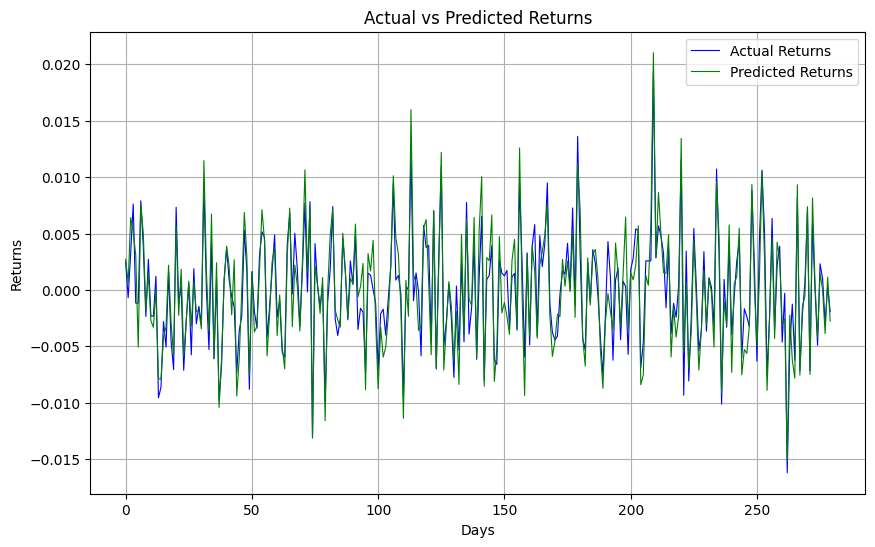

In [ ]:

df = pd.read_csv('/content/drive/My Drive/mtp/returns_predictions.csv')  # Replace with the actual path to the file

# Plotting the actual vs predicted returns
plt.figure(figsize=(10, 6))
plt.plot(df['Actual Returns'], color="blue", label="Actual Returns", linewidth=0.8)
plt.plot(df['Predicted Returns'], color="green", label="Predicted Returns", linewidth=0.8)

# Adding labels and legend
plt.title("Actual vs Predicted Returns")
plt.xlabel("Days")
plt.ylabel("Returns")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


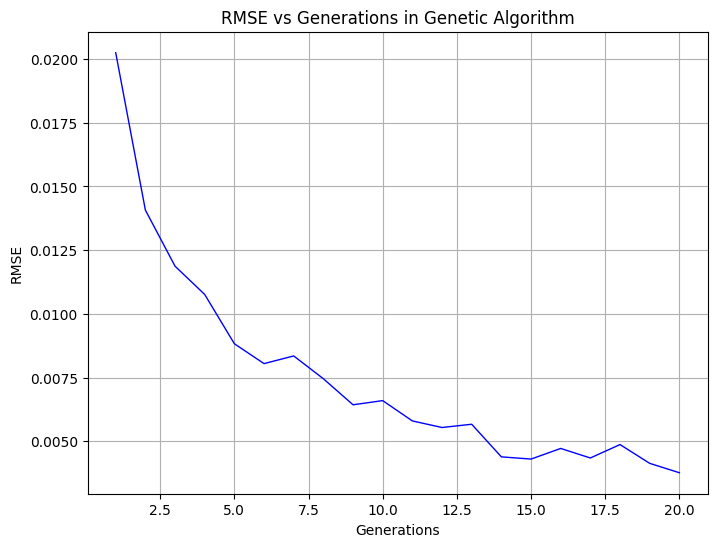

In [ ]:
df_ga = pd.read_csv('/content/drive/My Drive/mtp/rmse_vs_gen.csv')  # Replace with the actual path to the file

# Plotting RMSE vs Generation
plt.figure(figsize=(8, 6))
plt.plot(df_ga['Generation'], df_ga['RMSE'], color="blue", linewidth=1)

# Adding labels and title
plt.title("RMSE vs Generations in Genetic Algorithm")
plt.xlabel("Generations")
plt.ylabel("RMSE")
plt.grid(True)

# Show the plot
plt.show()

In [ ]:
rmse_df = pd.read_csv('/content/drive/My Drive/mtp/rmse_of_stocks.csv')

total_rmse = 0
num_stocks = len(all_files)

for filename, rmse_score in zip(all_files, rmse_df['rmse_of_stocks']):

    stock_name = os.path.splitext(os.path.basename(filename))[0]

    print(f"Stock: {stock_name}, RMSE: {rmse_score}")

    total_rmse += rmse_score

average_rmse = total_rmse / num_stocks if num_stocks > 0 else 0

print(f"Average RMSE: {average_rmse}")

Stock: Quote-Equity-ITC-EQ-25-07-2024-to-25-10-2024, RMSE: 0.0165904707254559
Stock: Quote-Equity-SBILIFE-EQ-25-07-2024-to-25-10-2024, RMSE: 0.0099514658763844
Stock: Quote-Equity-BRITANNIA-EQ-25-07-2024-to-25-10-2024, RMSE: 0.0011755859911712
Stock: Quote-Equity-KOTAKBANK-EQ-25-07-2024-to-25-10-2024, RMSE: 0.0115578262489447
Stock: Quote-Equity-SUNPHARMA-EQ-25-07-2024-to-25-10-2024, RMSE: 0.0117537287270164
Stock: Quote-Equity-CIPLA-EQ-25-07-2024-to-25-10-2024, RMSE: 0.0244488830581871
Stock: Quote-Equity-TCS-EQ-25-07-2024-to-25-10-2024, RMSE: 0.010120157971944
Stock: Quote-Equity-NESTLEIND-EQ-25-07-2024-to-25-10-2024, RMSE: 0.0028005385909977
Stock: Quote-Equity-ICICIBANK-EQ-25-07-2024-to-25-10-2024, RMSE: 0.0216046899091677
Stock: Quote-Equity-AXISBANK-EQ-25-07-2024-to-25-10-2024, RMSE: 0.001637261124825
Stock: Quote-Equity-ASIANPAINT-EQ-25-07-2024-to-25-10-2024, RMSE: 0.0022105397313288
Stock: Quote-Equity-HCLTECH-EQ-25-07-2024-to-25-10-2024, RMSE: 0.0097180667577031
Stock: Quote-E

**Portfolio Optimisation**

In [ ]:
returns_df = pd.DataFrame()

# Read returns for each stock to form a DataFrame
for filename in all_files:
    stock_name = os.path.basename(filename)
    df = pd.read_csv(filename)
    if 'Return' in df.columns:
        # Store returns in the DataFrame
        returns_df[stock_name] = df['Return']


In [ ]:
with open('/content/drive/My Drive/mtp/sortedstocks.pkl', 'rb') as file:
    sortedstocks = pickle.load(file)

top_stocks = sortedstocks[:6]
returns_df_top = returns_df[top_stocks]  # Filter only the top 6 stocks' returns

# Calculate mean returns and covariance matrix for these 6 stocks
mean_returns = returns_df_top.mean().values  # Mean returns of the selected stocks
cov_matrix = returns_df_top.cov().values  # Covariance matrix of the selected stocks

# Number of stocks in the portfolio
num_stocks = len(top_stocks)


In [ ]:
print(sortedstocks)

['Quote-Equity-NTPC-EQ-25-07-2024-to-25-10-2024.csv', 'Quote-Equity-LT-EQ-25-07-2024-to-25-10-2024.csv', 'Quote-Equity-HDFCBANK-EQ-25-07-2024-to-25-10-2024.csv', 'Quote-Equity-SUNPHARMA-EQ-25-07-2024-to-25-10-2024.csv', 'Quote-Equity-HCLTECH-EQ-25-07-2024-to-25-10-2024.csv', 'Quote-Equity-BPCL-EQ-25-07-2024-to-25-10-2024.csv', 'Quote-Equity-ADANIENT-EQ-25-07-2024-to-25-10-2024.csv', 'Quote-Equity-HINDUNILVR-EQ-25-07-2024-to-25-10-2024.csv', 'Quote-Equity-CIPLA-EQ-25-07-2024-to-25-10-2024.csv', 'Quote-Equity-INDUSINDBK-EQ-25-07-2024-to-25-10-2024.csv', 'Quote-Equity-SBILIFE-EQ-25-07-2024-to-25-10-2024.csv', 'Quote-Equity-HINDALCO-EQ-25-07-2024-to-25-10-2024.csv', 'Quote-Equity-TATASTEEL-EQ-25-07-2024-to-25-10-2024.csv', 'Quote-Equity-KOTAKBANK-EQ-25-07-2024-to-25-10-2024.csv', 'Quote-Equity-NESTLEIND-EQ-25-07-2024-to-25-10-2024.csv', 'Quote-Equity-SHRIRAMFIN-EQ-25-07-2024-to-25-10-2024.csv', 'Quote-Equity-GRASIM-EQ-25-07-2024-to-25-10-2024.csv', 'Quote-Equity-AXISBANK-EQ-25-07-2024-to-2

**1. Monte Carlo Simulation**

In [ ]:
np.random.seed(1000)

NoPortfolios = 50000
weight = np.zeros((NoPortfolios, num_stocks))
expReturn = np.zeros(NoPortfolios)
expVolatility = np.zeros(NoPortfolios)
sharpeRatio = np.zeros(NoPortfolios)

# Mean returns and covariance matrix are already calculated as `mean_returns` and `cov_matrix`
# We multiply the mean returns by 252 to annualize, as we're assuming daily returns
mean_log_return = mean_returns * 252
cov = cov_matrix

for k in range(NoPortfolios):
    # Random weight vector
    w = np.array(np.random.random(num_stocks))
    w = w / np.sum(w)
    weight[k, :] = w

    # Expected log return of the portfolio
    expReturn[k] = np.sum(mean_log_return * w)

    # Volatility of the portfolio
    expVolatility[k] = np.sqrt(np.dot(w.T, np.dot(cov, w))) * np.sqrt(252)

    # Sharpe Ratio (using a risk-free rate of 0.09581 as in the original code)
    sharpeRatio[k] = (expReturn[k] - 0.09581) / expVolatility[k]


In [ ]:
## Sharpe Ratio Maximization
maxIndex= sharpeRatio.argmax()
print('Optimal Weights:', weight[maxIndex, :])
print('Sharpe Ratio:', sharpeRatio.max())
print()
print('Expected Annualized Return', expReturn[maxIndex])
print('Annualized Volatility', expVolatility[maxIndex])

Optimal Weights: [0.01462076 0.02172192 0.3226014  0.22662242 0.39494902 0.01948448]
Sharpe Ratio: 3.0368236731650438

Expected Annualized Return 0.4548790763937491
Annualized Volatility 0.11823836845275888


In [ ]:
np.sum(weight[maxIndex, :])

1.0

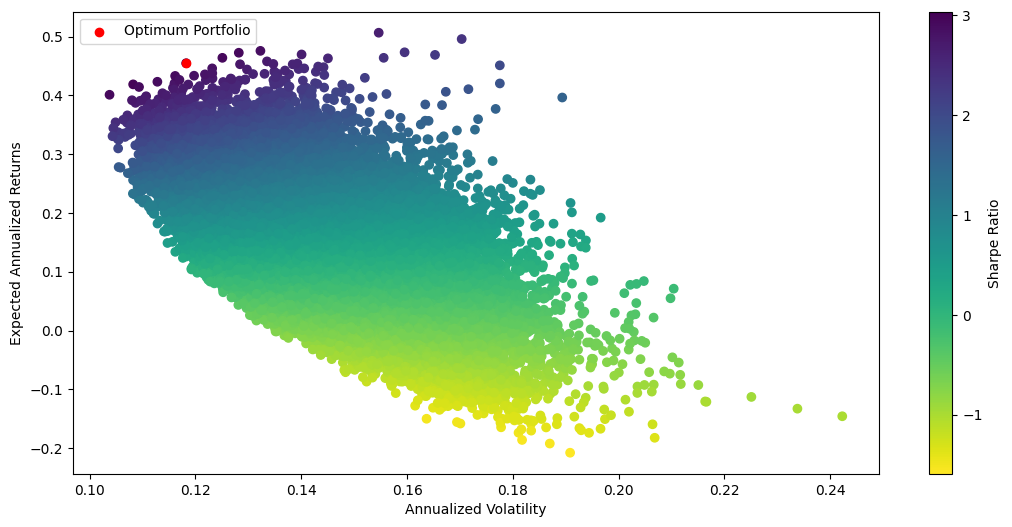

In [ ]:

plt.figure(figsize=(13, 6))
# Scatter plot of portfolios with color mapping to the Sharpe Ratio
plt.scatter(expVolatility, expReturn, c=sharpeRatio, cmap='viridis_r')

# Label axes and color bar
plt.xlabel('Annualized Volatility')
plt.ylabel('Expected Annualized Returns')
plt.colorbar(label='Sharpe Ratio')  # Add color bar with label

# Find and mark the optimum portfolio (portfolio with the highest Sharpe Ratio)
maxIndex = sharpeRatio.argmax()  # Index of the portfolio with the maximum Sharpe Ratio
plt.scatter(expVolatility[maxIndex], expReturn[maxIndex], c='red', label='Optimum Portfolio')

# Add legend
plt.legend(loc='upper left')
plt.show()


**2. Markowitz model**

In [ ]:

# Markowitz model: Calculate optimal weights
omega_inv = np.linalg.inv(cov_matrix)  # Inverse of the covariance matrix for selected stocks
e = np.ones(num_stocks)  # Vector of ones for weight calculations
weights = (omega_inv @ e) / (e.T @ omega_inv @ e)  # Optimal weights for the portfolio

# Calculate portfolio return and volatility
portfolio_return = np.dot(weights, mean_returns)  # Expected return of the portfolio
portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))  # Volatility of the portfolio
sharpe_ratio = portfolio_return / portfolio_volatility  # Assuming a risk-free rate of 0

# Print results
print(f"Optimal weights for the top 6 stocks: {dict(zip(top_stocks, weights))}")
print(f"Portfolio Return: {portfolio_return:.4f}, Portfolio Volatility: {portfolio_volatility:.4f}, Sharpe Ratio: {sharpe_ratio:.4f}")

Optimal weights for the top 6 stocks: {'Quote-Equity-NTPC-EQ-25-07-2024-to-25-10-2024.csv': -0.04271289384103942, 'Quote-Equity-LT-EQ-25-07-2024-to-25-10-2024.csv': -0.007791940805951064, 'Quote-Equity-HDFCBANK-EQ-25-07-2024-to-25-10-2024.csv': 0.3573114829600732, 'Quote-Equity-SUNPHARMA-EQ-25-07-2024-to-25-10-2024.csv': 0.5625761763997772, 'Quote-Equity-HCLTECH-EQ-25-07-2024-to-25-10-2024.csv': 0.22742195426914927, 'Quote-Equity-BPCL-EQ-25-07-2024-to-25-10-2024.csv': -0.09680477898200927}
Portfolio Return: 0.0020, Portfolio Volatility: 0.0061, Sharpe Ratio: 0.3206


**3. Optimizing the function min ( lambda * risk + ( 1 - lambda ) * ( -returns ) )**

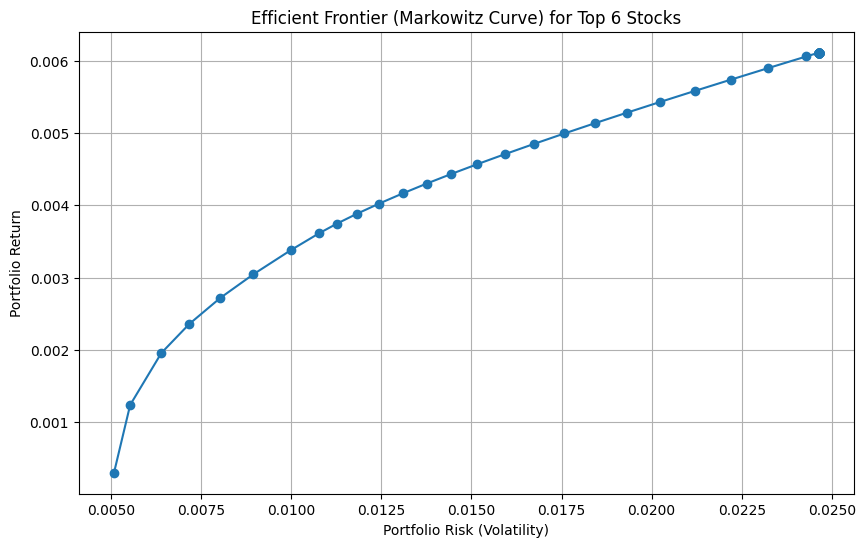

In [ ]:
returns_matrix = returns_df[sortedstocks].values
lambdas = np.linspace(0, 1, 100)

mean_returns = returns_matrix.mean(axis=0)  # Mean returns of the selected stocks

cov_matrix = np.cov(returns_matrix, rowvar=False)
# Store results for the efficient frontier
risks = []
returns = []

# Portfolio weights variable
w = cp.Variable(len(sortedstocks))

# Define constraints: weights sum to 1, and weights are non-negative
constraints = [cp.sum(w) == 1, w >= 0]

# Iterate over different λ values to find the optimal portfolio for each
for lam in lambdas:
    # Objective function: λ * Risk + (1 - λ) * (-Return)
    risk = cp.quad_form(w, cov_matrix)  # Risk term
    ret = w @ mean_returns          # Return term
    objective = cp.Minimize(lam * risk - (1 - lam) * ret)

    # Define and solve the optimization problem
    problem = cp.Problem(objective, constraints)
    problem.solve()

    # Check solver status
    if problem.status == cp.OPTIMAL:
        risks.append(np.sqrt(risk.value))  # Accessing the value of the CVXPY expression
        returns.append(ret.value)
    else:
        # Print detailed status if the optimization did not converge
        print(f"Warning: Optimization did not converge for λ = {lam:.2f}, status: {problem.status}")

# Plotting the efficient frontier
plt.figure(figsize=(10, 6))
plt.plot(risks, returns, marker='o')
plt.xlabel("Portfolio Risk (Volatility)")
plt.ylabel("Portfolio Return")
plt.title("Efficient Frontier (Markowitz Curve) for Top 6 Stocks")
plt.grid(True)
plt.show()